In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

def parse_data_line(data_line):
    """Return a tuple of the label as just FAKE or REAL and the statement"""
    return (data_line[1], data_line[2])

def pre_process(text):
    """Return a list of tokens"""
    return text.split()

In [ ]:
# test
text = "RT @colonelkickhead: Another bloody instant restaurant week?!?! Seriously! They just jumped the shark riding two other sharks powered by sh…"
pre_process(text)

['RT',
 '@colonelkickhead:',
 'Another',
 'bloody',
 'instant',
 'restaurant',
 'week?!?!',
 'Seriously!',
 'They',
 'just',
 'jumped',
 'the',
 'shark',
 'riding',
 'two',
 'other',
 'sharks',
 'powered',
 'by',
 'sh…']

In [ ]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    feature_vector = {}

    for token in tokens: # iterating each token from the pre-processed text (list of tokens)
      if token not in global_feature_dict:
        global_feature_dict[token] = len(global_feature_dict) # incrementally including new tokens to the vocabulary of features

      feature_vector[token] = 1 #assigning weight 1 for each token in sentence

    return feature_vector

In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        train_set = dataset[ : i] + dataset[i+fold_size : ] # the train set contains the remaining rows apart from the fold
        test_set = dataset[i : i+fold_size] # the test set contains the rows within the fold

        classifier = train_classifier(train_set)

        test_data = [row[0] for row in test_set] #list comprehension to get all the text data in the test set
        y_true = [row[1] for row in test_set] #list comprehension to get all the corresponding text labels in the test set

        #checking to see if the dataset is imbalanced (It is imbalanced by observation)
        #pos_counts = np.sum([1 for label in y_true if label == "positive"])
        #neg_counts = np.sum([1 for label in y_true if label == "negative"])
        #print(f"No.of texts with positive sentiment: {pos_counts}")
        #print(f"No.of texts with negative sentiment: {neg_counts}")

        y_pred = predict_labels(test_data, classifier)

        accuracy = accuracy_score(y_true, y_pred)

        #using weighted average to compute the metrics since dataset is imbalanced
        precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

        results.append({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1_score})
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

        '''Performing error analysis (as stated in Question #3) on the first fold'''
        if i == 0:
            print("---------------------------------------Error Analysis on the first fold (as per Question #3)-----------------------------------------------")
            labels = ["positive", "negative"]
            confusion_matrix_heatmap(y_true, y_pred, labels)

            #using list comprehension to identify the true positives and true negatives for the positive class in the first fold
            true_positives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "positive" and y_true[j] == "positive"]
            true_negatives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "negative" and y_true[j] == "negative"]

            #using list comprehension to identify the false positives and false negatives for the positive class in the first fold
            false_positives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "positive" and y_true[j] == "negative"]
            false_negatives = [test_data[j] for j in range(len(y_pred)) if y_pred[j] == "negative" and y_true[j] == "positive"]

            print("Number of false positives: ",len(false_positives))
            print("Number of false negatives: ", len(false_negatives))

            batch_of_true_positives = true_positives[:5] #5 examples to just show
            batch_of_true_negatives = true_negatives[:5] #5 examples to just show
            batch_of_false_positives = false_positives[:5] #5 examples to just show
            batch_of_false_negatives = false_negatives[:5] #5 examples to just show

            print("\n")
            print("First 5 examples of False Positives:")
            for false_pos in false_positives[:5]:
                print(false_pos)

            print("\n")
            print("First 5 examples of False Negatives:")
            for false_neg in false_negatives[:5]:
                print(false_neg)

            print("\n")
            print("First 5 examples of True Positives:")
            for false_pos in true_positives[:5]:
                print(false_pos)

            print("\n")
            print("First 5 examples of True Negatives:")
            for false_neg in true_negatives[:5]:
                print(false_neg)
            print("--------------------------------------------------------------------------------------------------------------------------------------------")

    accuracies = [result["accuracy"] for result in results]
    precisions = [result["precision"] for result in results]
    recalls = [result["recall"] for result in results]
    f1_scores = [result["f1_score"] for result in results]

    cv_results = {"accuracy" : float(np.mean(accuracies)), "precision" : float(np.mean(precisions)),
                  "recall" : float(np.mean(recalls)), "f1_score" : float(np.mean(f1_scores))}

    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
104038


Fold start on items 0 - 2684
Training Classifier...
Accuracy: 0.834575260804769, Precision: 0.8320493302857344, Recall: 0.834575260804769, F1 Score: 0.8329316888419199
---------------------------------------Error Analysis on the first fold (as per Question #3)-----------------------------------------------


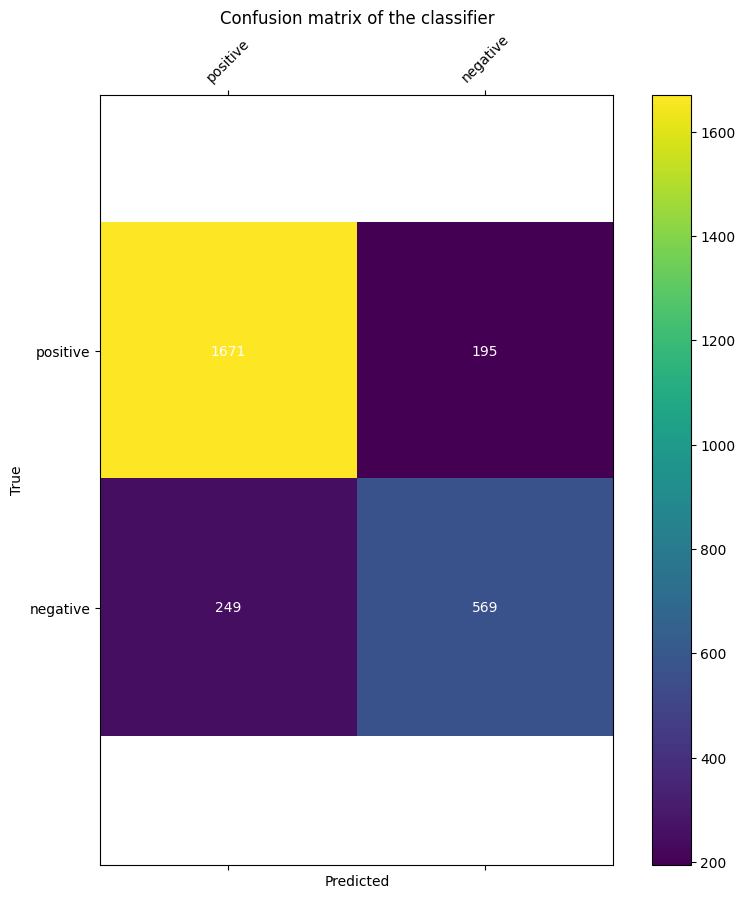

Number of false positives:  249
Number of false negatives:  195


First 5 examples of False Positives:
{'@CheleReamey': 1, '@funder': 1, '@ZeldaShagnasty': 1, '@FBI': 1, '@TheJusticeDept': 1, 'yes': 1, 'I': 1, 'know': 1, 'but': 1, 'Comey': 1, 'should': 1, 'be': 1, 'pressured': 1, 'for': 1, 'further': 1, 'explanation': 1, 'about': 1, 'letter': 1, '.': 1}
{"Nicki's": 1, 'pastor': 1, 'is': 1, 'mad': 1, 'af': 1, 'right': 1, 'now.': 1, 'And': 1, "it's": 1, 'Sunday': 1, 'smh': 1}
{'Well': 1, 'with': 1, 'Zayn': 1, 'joining': 1, 'ISIS': 1, 'it': 1, 'is': 1, 'hard': 1, 'to': 1, 'maintain': 1, 'their': 1, 'family': 1, 'friendly': 1, 'image.': 1, 'https://t.co/ObzEtFCpPg': 1}
{'The': 1, 'ONE': 1, 'time': 1, 'we': 1, 'want': 1, 'to': 1, 'use': 1, 'the': 1, 'Amazon': 1, 'Prime': 1, 'streaming': 1, 'and': 1, "it's": 1, 'down...': 1, 'grrr': 1, 'ruined': 1, 'my': 1, 'Sunday': 1, 'night!': 1, '@AmazonUK': 1}
{'@LumiaUS': 1, 'The': 1, '1520': 1, 'is': 1, 'the': 1, 'first': 1, 'Nokia': 1, 'I': 1, 'have'

{'accuracy': 0.8304664857796521,
 'precision': 0.8286815927108229,
 'recall': 0.8304664857796521,
 'f1_score': 0.8288550081319425}

In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

In [ ]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'Tomorrow': 1, "we'll": 1, 'release': 1, 'our': 1, '58th': 1, 'episode': 1, 'of': 1, '#HSonAir': 1, 'profiling': 1, 'very': 1, 'own': 1, '@AlissaDosSantos': 1, '!': 1, "We'll": 1, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'Beyonce!': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.833870
Recall: 0.835719
F Score:0.834303


In [ ]:
#A more robust and advanced version of this is present in SVM_Tweet_Sentiment_Anlysis.ipynb